# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT.

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class.
The classifier should be able to handle binary and continuous features.
To earn the bonus points, the classifier should be able to handle categorical features as well.
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**.
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries.

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/My Drive/Colab Notebooks/FDS/Practical 2

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/FDS/Practical 2


### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**.

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE).
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data.

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$.

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions.

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors.
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [3]:
from scipy.stats import norm, binom

ALPHA = 1.0 # for additive smoothing
SMALL_V = 1e-6

# Distribution for continuous features
class ContFeatureParam:

    def __init__(self, X):
        self.X = X
        self.mu = 0
        self.std = SMALL_V
        self.norm = []

    def estimate(self):
        # TODO: Estimate the parameters for the Gaussian distribution
        # so that it best describes the input data X
        self.mu = np.mean(self.X)
        self.std = np.std(self.X)
        self.norm = norm(loc=self.mu, scale=self.std)

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        return self.norm.logpdf(X_new)

# Distribution for binary features
class BinFeatureParam:

    def __init__(self, X):
        self.X = X
        self.p = 0
        self.n = 0
        self.binomial = []

    def estimate(self):
        # TODO: Estimate the parameters for the Bernoulli distribution
        # so that it best describes the input data X
        # X is a vector with binary values
        counts_success = np.sum(self.X)
        assert len(self.X) - np.count_nonzero(self.X == 0) == counts_success
        self.n = len(self.X) + 2 * ALPHA
        self.p = (counts_success + ALPHA) / self.n
        self.binomial = binom(n=self.n, p=self.p)

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        return [np.log(self.p) if x == 1 else np.log(1 - self.p) for x in X_new]

# Distribution for categorical features
class CatFeatureParam:

    # we need to know the number of categories for the categorical feature
    def __init__(self, X, num_of_categories):
        self._num_of_categories = num_of_categories
        self.X = X
        self.p = []
        self.multinomial = {}

    def estimate(self):
        # TODO: Estimate the parameters for the Multinoulli distribution
        # so that it best describes the input data X
        counts = np.bincount(self.X)
        assert len(counts) == self._num_of_categories
        smoothed_counts = counts + ALPHA
        total_counts = np.sum(smoothed_counts)
        self.p = smoothed_counts / total_counts
        self.multinomial = {i: value for i, value in enumerate(self.p)}

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # print([self.multinomial[x] if x in self.multinomial else 0 for x in X_new][-20])
        return [np.log(self.multinomial[x]) if x in self.multinomial else SMALL_V for x in X_new]

**Tests:**
    
We will use the code below to test the correctness of your code.

In [4]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam(X)
param.estimate()
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [5]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam(X)
param.estimate()
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.8754687373539001, -0.5389965007326869]


In [6]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(X, num_of_categories=10)
param.estimate()
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.9459101490553135, -2.169053700369523, -1.9459101490553135, -2.456735772821304, -2.169053700369523, -2.8622008809294686, -1.9459101490553135, -3.5553480614894135, -2.169053700369523, -2.8622008809294686]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data.

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [7]:
# Your task is to implement the three functions of NBC.

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        self.feature_types = feature_types
        self.labels = []
        self.counts = []
        self.theta = {}

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        self.labels, self.counts = np.unique(y, return_counts=True)

        for label in self.labels:
            for i, feature in enumerate(self.feature_types):
                X_jc = X[y==label, i]
                jc = f"{i}_{label}"

                if feature == "b":
                    param = BinFeatureParam(X_jc)
                    param.estimate()
                    self.theta[jc] = param
                if feature == "r":
                    param = ContFeatureParam(X_jc)
                    param.estimate()
                    self.theta[jc] = param
                if feature == "c":
                    categories = np.bincount(X_jc)
                    param = CatFeatureParam(X_jc, num_of_categories=len(categories))
                    param.estimate()
                    self.theta[jc] = param

    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X_new):
        result = []
        for idx, label in enumerate(self.labels):
            prob = np.log(self.counts[idx] / np.sum(self.counts))

            p = np.zeros(X_new.shape[0])

            for i, feature in enumerate(self.feature_types):
                X_jc = X_new[:, i]
                jc = f"{i}_{label}"
                p = np.add(p, self.theta[jc].get_log_probability(X_jc))

            p = p + prob
            result.append(p)

        comparison = np.array(result)
        return np.argmax(comparison, axis=0)

**Tests**

We will use the code below to check your code.

In [8]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [9]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
#data = pd.read_csv('./sample_data/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [10]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
#data = pd.read_csv('./sample_data/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat)

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [11]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets.
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data.
We have written for you the function for making the plots for the experiments.

In [12]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps.
# outputs:
#   the arrays of the test errors across the runs of the two classifiers

from tqdm import tqdm

def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    tst_errs_nbc = [SMALL_V] * num_splits
    tst_errs_lr = [SMALL_V] * num_splits

    N, D = X.shape
    Ntrain = int(0.8 * N)
    n_classes = len(set(y))

    np.seterr(divide="ignore", invalid="ignore")

    for n in tqdm(range(num_runs)):

        # Enforces that all the classes are present in the train set
        while True:
            shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:Ntrain]]
            ytrain = y[shuffler[:Ntrain]]
            Xtest = X[shuffler[Ntrain:]]
            ytest = y[shuffler[Ntrain:]]
            smallest_portion = int((0 + 1)/10 * Xtrain.shape[0])
            ytrain_smallest = ytrain[:smallest_portion]
            if len(set(ytrain_smallest)) == n_classes:
                break

        for i in range(num_splits):
            portion = int((i + 1)/10 * Xtrain.shape[0])
            Xsplit = Xtrain[:portion]
            ysplit = ytrain[:portion]

            nbc.fit(Xsplit, ysplit)
            yhat = nbc.predict(Xtest)
            nbc_errors = 1 - np.mean(yhat == ytest)
            tst_errs_nbc[i] += nbc_errors

            lr.fit(Xsplit, ysplit)
            lr_errors = 1 - clf_lr.score(Xtest, ytest)
            tst_errs_lr[i] += lr_errors

    return [x / num_runs for x in tst_errs_nbc], [x / num_runs for x in tst_errs_lr]

In [13]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')

    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. Prepare the data for the two classifiers, e.g., handle missing values and the categorical data. When you handle the categorical data, you should check whether the data is ordinal or not. If the data is ordinal, you should encode the data as integers. If the data is not ordinal, you should encode the data as one-hot vectors.
2. Show the first 5 rows of the prepared data
3. Compare the two classifiers on the dataset and generate the plots

The grading will be based on whether the data is correctly prepared and the plots are generated without errors. The grading will not be based on the performance of the classifiers and whether the plots are the same as in the paper.

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

**Data preparation:**

- The exporation of the Iris dataset showed that there are no missing values and the dataset is balanced (each class is presented equally).

- Considering standardization, we decided to not do it, we performed experiments on the Iris dataset as it is.

Taking into account that this dataset contains 3 classes, we chose for the logistic regression the following parameters: multi_class='multinomial', solver='lbfgs'.

100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


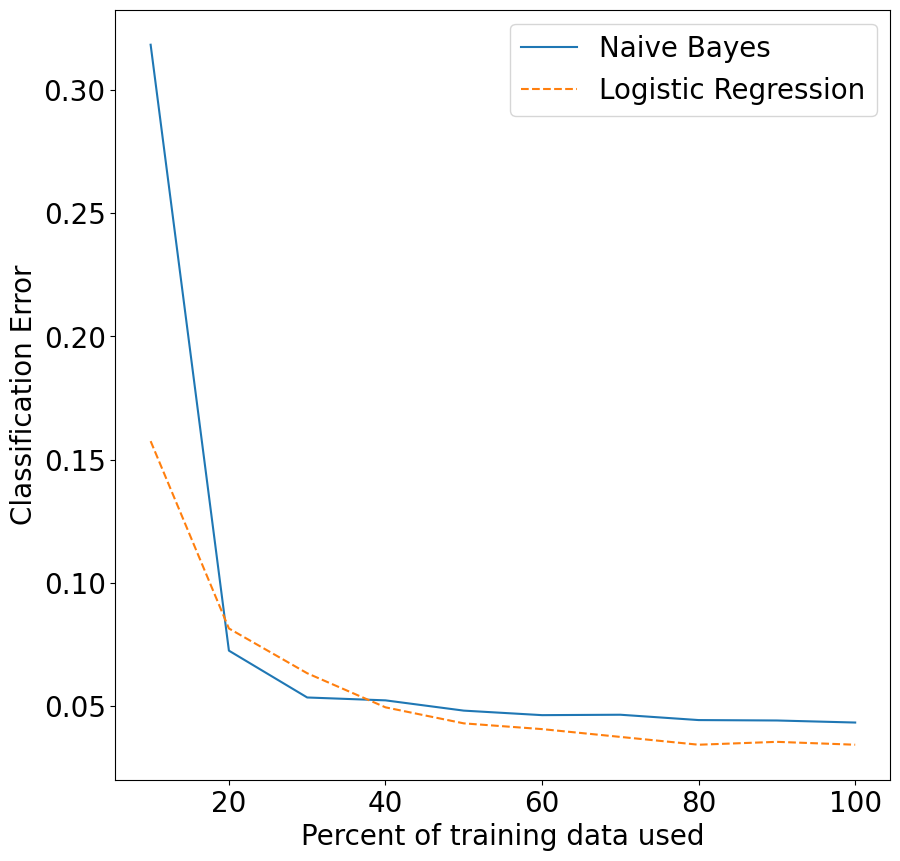

In [14]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris['data'], iris['target']

feature_types = ['r', 'r', 'r', 'r']
clf_NBC = NBC(feature_types)
clf_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

nbc_perf, lr_perf = compareNBCvsLR(clf_NBC, clf_lr, X, y)
makePlot(nbc_perf, lr_perf)

In [15]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot.

**Data preparation:**

- The original Voting data set contained missing values, thus we decided to drop one column that contains a lot of missing values (export-administration-act-south-africa) and fill in missing values with a mode of the corresponding feature - for all the other columns.

- We also encoded labels ("democrat", "republican") into 1s and 0s.

- All the features of this dataset are binary ("y", "n"), thus, we encoded them into 1s and 0s as well.

Since the dataset is binary, we performed logistic regression with defaut arguments (the only change was max_iter=1000).

100%|██████████| 200/200 [01:21<00:00,  2.45it/s]


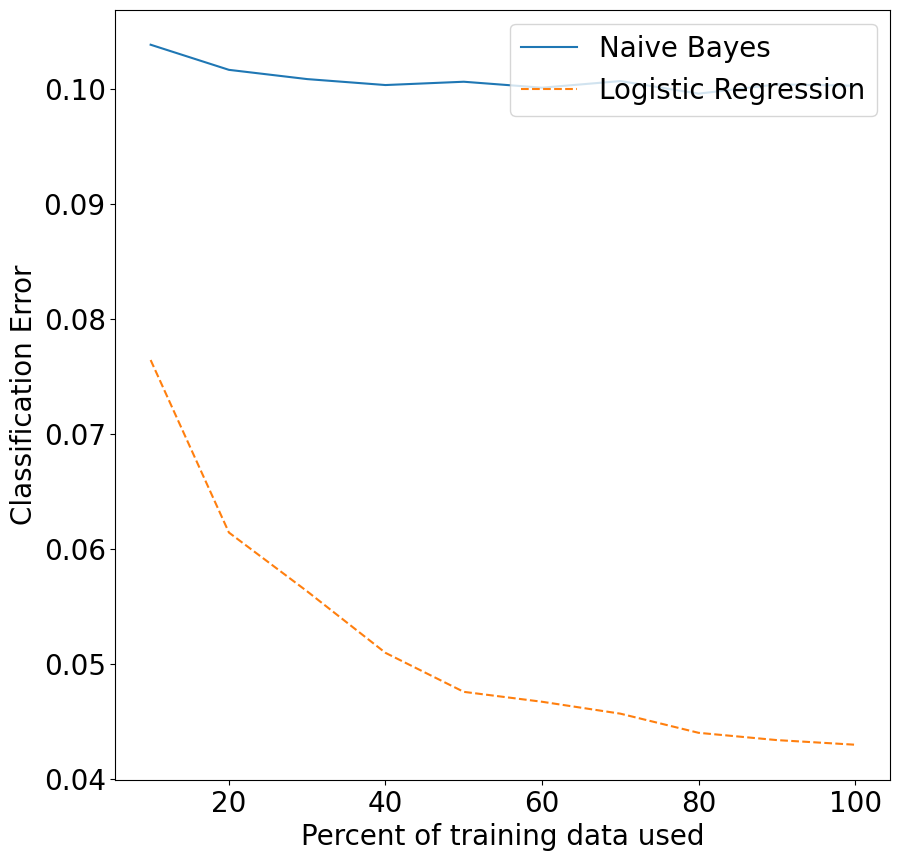

In [16]:
voting = pd.read_csv('./datasets/voting.csv')
#voting = pd.read_csv('./sample_data/voting.csv')

voting["label"] = voting["label"].map({"republican": 0, "democrat": 1})

voting = voting.drop(["export-administration-act-south-africa"], axis=1)

feature_columns = voting.columns.drop("label")
voting[feature_columns] = voting[feature_columns].apply(lambda x: x.map({"y": 1, "n": 0}))

for column in feature_columns:
    mode = voting[column].mode()[0]
    voting[column].fillna(mode, inplace=True)

voting[feature_columns] = voting[feature_columns].astype(int)

X = voting.drop("label", axis=1).to_numpy()
y = voting["label"].to_numpy()

feature_types = ["b"] * len(feature_columns)
clf_NBC = NBC(feature_types)
clf_lr = LogisticRegression(max_iter=1000)

nbc_perf, lr_perf = compareNBCvsLR(clf_NBC, clf_lr, X, y)
makePlot(nbc_perf, lr_perf)

In [17]:
voting.head()

,label,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0
1,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0
2,1,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0
3,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0
4,1,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1


**Dataset 3: Breast Cancer Dataset (Bonus Tasks)**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

The dataset has continues, binary and categorical features. It also has missing values.

Hints: You can precompute the size of the domains of the categorical features.

In [18]:
cancer = pd.read_csv('./datasets/breast-cancer.csv')
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


**Data preparation:**

According to the description of the dataset on the web site, it has missing values, but info() didn't detect them, thus we went feature by feature to find them.

The result is as follows:

1) there are:
- 3 binary features (node-caps, breast, irradiat)
- 4 ordinal features (age, tumor-size, inv-nodes, deg-malig)
- 2 categorical features (menopause, breast-quad)

2) 2 features have missing data (node-caps, breast-quad)

First, we replace missing data with the mode of the feature and then check that our columns don't have missing values anymore.

Next, we encode binary, ordinal and categorical features.

In [19]:
# Replace missing values in 2 columns with the mode of this columns
column_names = ['node-caps', 'breast-quad']

value_to_replace = '?'
for col in column_names:
  mode_value = cancer[col].mode().iloc[0]
  cancer[col] = cancer[col].replace(value_to_replace, mode_value)

In [20]:
# No missing values anymore
node_caps_counts = cancer['node-caps'].value_counts()
print(node_caps_counts)

print("--------------------------")

breast_quad_counts = cancer['breast-quad'].value_counts()
print(breast_quad_counts)

no     230
yes     56
Name: node-caps, dtype: int64
--------------------------
left_low     111
left_up       97
right_up      33
right_low     24
central       21
Name: breast-quad, dtype: int64


In [21]:
# Binary transformation

binary_columns = ['Class', 'breast', 'irradiat', 'node-caps']
binary_mapping = {
    'Class': {"no-recurrence-events": 0, "recurrence-events": 1},
    'breast': {"left": 0.0, "right": 1.0},
    'irradiat': {"no": 0.0, "yes": 1.0},
    'node-caps': {"no": 0.0, "yes": 1.0}
}

for column in binary_columns:
    cancer[column] = cancer[column].map(binary_mapping[column])


# Transformation of ordinal features (age, tumor-size, inv-nodes)

from sklearn.preprocessing import OrdinalEncoder

ordinal_columns = ['age', 'tumor-size', 'inv-nodes', 'deg-malig']

age_categories = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
tumor_size_categories = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54']
inv_nodes_categories = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '24-26']
delig_categories = [1, 2, 3]

custom_order = [age_categories, tumor_size_categories, inv_nodes_categories, delig_categories]

encoder = OrdinalEncoder(categories=custom_order)
cancer[ordinal_columns] = encoder.fit_transform(cancer[ordinal_columns])

# Transformation of categorical features (menopause, breast-quad)

from sklearn.preprocessing import OneHotEncoder
categorical_columns = ['menopause', 'breast-quad']

for feature in categorical_columns:
    one_hot_encoder = OneHotEncoder(drop='first')
    cat_encoded = one_hot_encoder.fit_transform(cancer[[feature]])
    onehot_df = pd.DataFrame(cat_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out([feature]))
    cancer = pd.concat([cancer, onehot_df], axis=1).drop([feature], axis=1)


cancer = cancer.astype(int)
cancer.head()

,Class,age,tumor-size,inv-nodes,node-caps,deg-malig,breast,irradiat,menopause_lt40,menopause_premeno,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,0,1,6,0,0,2,0,0,0,1,1,0,0,0
1,0,2,4,0,0,1,1,0,0,1,0,0,0,1
2,0,2,4,0,0,1,0,0,0,1,1,0,0,0
3,0,4,3,0,0,1,1,0,0,0,0,1,0,0
4,0,2,0,0,0,1,1,0,0,1,0,0,1,0


In [22]:
# Create an array feature_types
feature_types = []
for column in cancer.columns:
    if column != 'Class':
        if cancer[column].nunique() == 2:
            feature_types.append('b')
        else:
            feature_types.append('c')

feature_types

['c', 'c', 'c', 'b', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

100%|██████████| 200/200 [01:08<00:00,  2.94it/s]


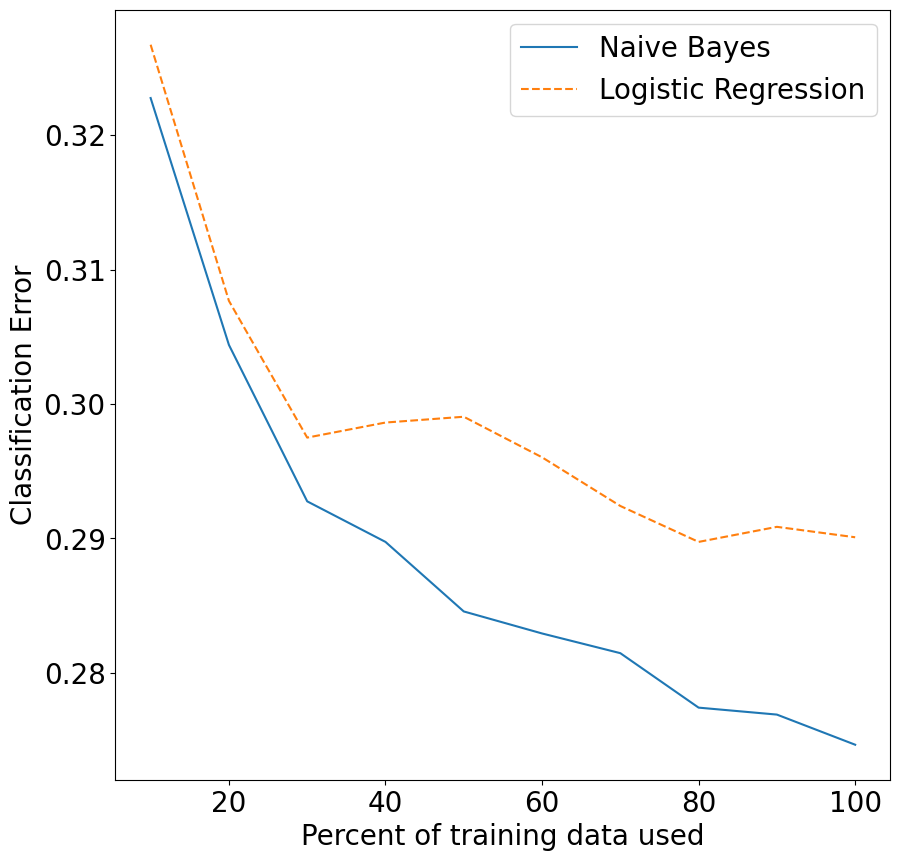

In [23]:
X = cancer.drop("Class", axis=1).to_numpy()
y = cancer["Class"].to_numpy()

clf_NBC = NBC(feature_types)
clf_lr = LogisticRegression(max_iter=1000)

nbc_perf, lr_perf = compareNBCvsLR(clf_NBC, clf_lr, X, y)
makePlot(nbc_perf, lr_perf)